# Zonal Statistics

In this tutorial, you'll learn how to use [xarray-spatial](https://xarray-spatial.org/) to work with zonal statistics. Zonal statistics help you better understand data from one source by analyzing it for different zones defined by another source. This operation uses two datasets: One dataset, the *zones raster*, defines one or more zones. A second dataset, the *values raster*, contains the data you want to analyze for each of the zones defined by the first dataset.

In this example, you will use three datasets: [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem), [Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a), and [Esri 10m Land Use/Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc). As your *zones raster*, you will generate five elevation classes from the NASADEM dataset and use those classes as the different zones to analyze data for. The remaining two datasets are used as *values rasters*: You will analyze [Normalized difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) data from the Sentinel-2 dataset and [land use classes](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac) from the Esri dataset.

This tutorial covers the following steps:

- Load and align [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem), [Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a), and [Esri 10m Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc) data.
- Classify the [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem) data into elevation zones.
- Compute [zonal statistics](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) using the elevation zones from the [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem) data and [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) values based on [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) data.
- Compute average [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) by the [Esri 10m Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc) data classes as a use case of [zonal statistics](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html).
- Compute [cross-tabulation statistics](https://en.wikipedia.org/wiki/Contingency_table) using the [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem)-based elevation zones and land cover values from the [Esri Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc) data.

In [1]:
import numpy as np

import planetary_computer as pc
import pystac_client
import stackstac
import rasterio

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from xrspatial import hillshade
from xrspatial.multispectral import true_color, ndvi

from xrspatial.classify import equal_interval
from xrspatial.zonal import stats as zonal_stats
from xrspatial.zonal import crosstab as zonal_crosstab

## Preparation: Create a local Dask cluster

In this tutorial, you'll be using a small dataset. Create a local Dask cluster to process the data in parallel using all the cores of your machine.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


To follow the progress of your computation, you can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at the URL from the previous cell's output.

## Load and coregister data

The area of interest covers Lake Bridgeport, Texas, USA. Select the corresponding NASADEM scene and then load and process Sentinel and Esri Land Cover data that overlaps this NASADEM scene.

#### NASADEM data

Use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to identify a GeoTIFF that covers Lake Bridgeport.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
point = {"type": "Point", "coordinates": [-97.807733, 33.2133019]}

nasadem_search = catalog.search(collections=["nasadem"], intersects=point, limit=1)
nasadem_item = next(nasadem_search.get_items())

nasadem_item

<Item id=NASADEM_HGT_n33w098>

Use [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) to load the NASADEM data, reproject it to the [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) projection, and resample it to a resolution of 100m. These three operations all happen in a single step. See [Reprojecting](reprojection.ipynb) to learn more about reprojecting and resampling.

In [4]:
nasadem_data = (
    stackstac.stack(
        [pc.sign(nasadem_item).to_dict()],
        epsg=3857,  # reproject to Web Mecator
        resolution=100,  # resolution of output image
    )
    .isel(time=0, band=0)
    .persist()
)

# assign name for the data array
nasadem_data.name = "Elevation (NASADEM)"

nasadem_data.spec, nasadem_data.shape

(RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900, 4028900), resolutions_xy=(100, 100)),
 (1337, 1115))

#### Sentinel data

Use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to search for all Sentinel images that match the following criteria:
* overlap with the NASADEM scene you just selected
* have a cloud coverage of less than 10 percent
* are from July 2020

In [5]:
sentinel_search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=nasadem_item.geometry,
    datetime="2020-07-01/2020-07-30",
    query={
        "eo:cloud_cover": {
            "lt": 10,
        }
    },
)

sentinel_items = [pc.sign(item).to_dict() for item in sentinel_search.get_items()]
len(sentinel_items)

15

To align data from different datasets that initially have different reprojection and resolution settings, both data sets need to use the same resolution and the same [Coordinate Reference System(CRS)](https://gdal.org/tutorials/osr_api_tut.html). 
Load the Sentinel data with [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) and set the `resolution`, `epsg`, and `bounds` properties to match those of your NASADEM data. See [Coregistration](coregistration.ipynb) to learn more about aligning satellite images from different data sources.

By taking a median over 15 items in the time dimension, you can create a cloudless median composite. See [cloudless mosaic](cloudless-mosaic-sentinel2.ipynb) to learn more.

In [6]:
sentinel_data = (
    (
        stackstac.stack(
            sentinel_items,
            resolution=nasadem_data.resolution,  # resample to Nasadem data resolution
            epsg=nasadem_data.spec.epsg,  # reporoject to CRS of Nasadem data
            bounds=nasadem_data.spec.bounds,  # set bounds to match Nasadem data
            assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        )
        .where(lambda x: x > 0, other=np.nan)  # Sentinels uses 0 as nodata
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
    )
    .median(dim="time", keep_attrs=True)
    .persist()
)

sentinel_data.spec, sentinel_data.shape

(RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900, 4028900), resolutions_xy=(100, 100)),
 (4, 1337, 1115))

#### Esri land cover data

Similarly, use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to search for all Esri 10m Land Cover images that overlap with the selected NASADEM scene.

In [7]:
io_lulc_search = catalog.search(
    collections=["io-lulc"],
    intersects=nasadem_item.geometry,
)

io_lulc_items = [pc.sign(item).to_dict() for item in io_lulc_search.get_items()]
len(io_lulc_items)

4

Use [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) to load Esri's land cover data and align it to match your NASADEM data.

In [8]:
landcover_data = (
    stackstac.stack(
        io_lulc_items,
        resolution=nasadem_data.resolution,  # resample to Nasadem data resolution
        epsg=nasadem_data.spec.epsg,  # reporoject to CRS of Nasadem data
        bounds=nasadem_data.spec.bounds,  # set bounds to match Nasadem data
        assets=["data"],
    )
    .isel(time=-1, band=0)  # last time slice, data band
    .persist()
)

landcover_data.name = "Land Cover (Esri)"

landcover_data.spec, landcover_data.shape

(RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900, 4028900), resolutions_xy=(100, 100)),
 (1337, 1115))

Identify all land cover classes contained in the data you have prepared.

In [9]:
# create list of names of land cover classes
class_names = landcover_data.coords["label:classes"].item()["classes"]

# create dict of classes that are available in the data
landcover_data_classes = {
    i: class_names[int(i)] for i in np.unique(landcover_data.data).compute()
}

landcover_data_classes

{1.0: 'water',
 2.0: 'trees',
 3.0: 'grass',
 4.0: 'flooded veg',
 5.0: 'crops',
 6.0: 'scrub',
 7.0: 'built area',
 8.0: 'bare'}

The Esri data for the area of interest contains eight different land cover classes. See the [Esri 2020 Land Cover webpage at arcgis.com](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac) for more information about the class definitions used in this dataset.

A colormap has been defined as metadata in the source GeoTIFFs for the land cover data. Let's open the first STAC item found by the search for land cover data. You can read the colormap from there and construct the right colors for your plots.

In [10]:
class_count = len(landcover_data_classes)
min_class = min(landcover_data_classes.keys())

with rasterio.open(
    pc.sign(next(io_lulc_search.get_items()).assets["data"].href)
) as src:
    landcover_colormap_def = src.colormap(1)  # get metadata colormap for band 1
    landcover_colormap = [
        np.array(landcover_colormap_def[i + min_class]) / 255
        for i in range(class_count)
    ]  # transform to matplotlib color format

landcover_cmap = ListedColormap(landcover_colormap)

#### Visualize aligned data

To make visualizing multiple datasets easier, define a helper function that generates a layout of multiple images:

In [11]:
# helper function
def plot_imgs(imgs, cmaps=[], cats=[], figsize=(15, 7)):

    n_imgs = len(imgs)
    n_cmaps = len(cmaps)
    ncols = n_imgs + n_cmaps

    gridspec_kw = {
        "width_ratios": [
            *np.tile([1, 0.08], n_cmaps),
            *[1 for _ in range(n_imgs - n_cmaps)],
        ],
        "left": 0.0,
        "right": 1.0,
    }
    fig, ax = plt.subplots(
        nrows=1, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw
    )

    count_imgs = 0
    count_colorbars = 0
    i = 0
    while i < ncols:
        # get cmap for image
        cmap = None
        if count_colorbars < n_cmaps:
            cmap = plt.get_cmap(cmaps[count_colorbars])
            count_colorbars += 1
        # plot image
        im = ax[i].imshow(imgs[count_imgs].data, cmap=cmap)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(imgs[count_imgs].name)
        count_imgs += 1
        i += 1
        # plot colorbar (if any)
        if cmap is not None:
            if count_colorbars - 1 < len(cats):
                bounds = [-1, *range(len(cats[count_colorbars - 1]))]
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                cbar = fig.colorbar(
                    mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax[i]
                )
                cbar.set_ticklabels(["", *cats[count_colorbars - 1]])
            else:
                cbar = fig.colorbar(im, cax=ax[i])
            i += 1

    plt.show()

Render the NASADEM image with [xrspatial.hillshade](https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html):

In [12]:
hillshaded_nasadem_data = hillshade(
    nasadem_data, azimuth=100, angle_altitude=50, name="Hillshaded Elevation (NASADEM)"
)

Create a true color image for the Sentinel data:

In [13]:
sentinel_img = true_color(
    sentinel_data.sel(band="red"),
    sentinel_data.sel(band="green"),
    sentinel_data.sel(band="blue"),
    c=30,
    th=0.075,
    name="True color (Sentinel)",
)

Use the helper function you defined earlier to plot a layout of images based on the NASADEM, Esri Land Cover, and Sentinel data:

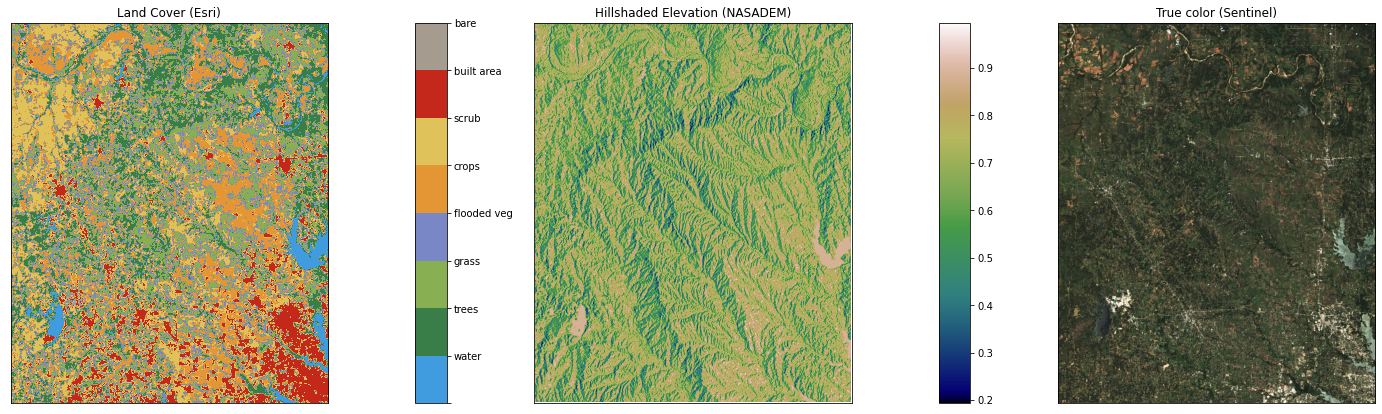

In [14]:
plot_imgs(
    imgs=[landcover_data, hillshaded_nasadem_data, sentinel_img],
    cmaps=[landcover_cmap, "gist_earth"],
    cats=[landcover_data_classes.values()],
    figsize=(20, 7),
)

## Create a zone raster

Zonal statistics operations are based on zones defined in a *zone raster*. The zone raster for the following examples consists of five distinctive zones that are based on the NASADEM elevation dataset. To define the different zones, classify the elevation data into different elevation categories. The zones in your zone raster correspond to these elevation classes. 

Divide the NASDEM elevation data into five quantile groups of equal size:

In [15]:
num_zones = 5

quantile_zones = equal_interval(
    nasadem_data, k=num_zones, name="Zones (Classified Elevation - NASADEM)"
)

quantile_zones.compute()

<xarray.DataArray 'Zones (Classified Elevation - NASADEM)' (y: 1337, x: 1115)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan,  1.,  2., ...,  1.,  1., nan],
       [nan,  2.,  1., ...,  1.,  1., nan],
       ...,
       [nan,  4.,  4., ...,  0.,  0., nan],
       [nan,  4.,  4., ...,  0.,  0., nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time            datetime64[ns] 2000-02-20
    id              <U19 'NASADEM_HGT_n33w098'
    band            <U9 'elevation'
  * x               (x) float64 -1.091e+07 -1.091e+07 ... -1.08e+07 -1.08e+07
  * y               (y) float64 4.029e+06 4.029e+06 ... 3.895e+06 3.895e+06
    proj:shape      object {3601}
    proj:transform  object {0.0, 1.0, 34.00013888888889, -0.00027777777777777...
    proj:epsg       int64 4326
    proj:bbox       object {32.999861111111116, -96.9998611111111, 34.0001388...
    title           <U9 'Elevation'
    epsg            int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900,...
    crs:         epsg:3857
    transform:   | 100.00, 0.00,-10909400.00|\n| 0.00,-100.00, 4028900.00|\n|...
    resolution:  100

Define name for all the zones.

In [16]:
elevation_zones = [f"zone {i}" for i in range(num_zones)]
elevation_zones

['zone 0', 'zone 1', 'zone 2', 'zone 3', 'zone 4']

## Compute zonal statistics

#### Statistics of NDVI values over Elevation zones

In addition to the zonal raster you just defined based on the NASADEM data, zonal statistics require a *value raster*. In this example, use the NDVI computed from Sentinel data as a value raster.

First, compute NDVI values from the Sentinel data you prepared earlier:

In [17]:
ndvi_values = ndvi(
    sentinel_data.sel(band="nir"),
    sentinel_data.sel(band="red"),
    name="Values (NDVI - Sentinel)",
)

Next, plot both the five NASADEM elevation classes and the Sentinel-based NDVI data next to each other:

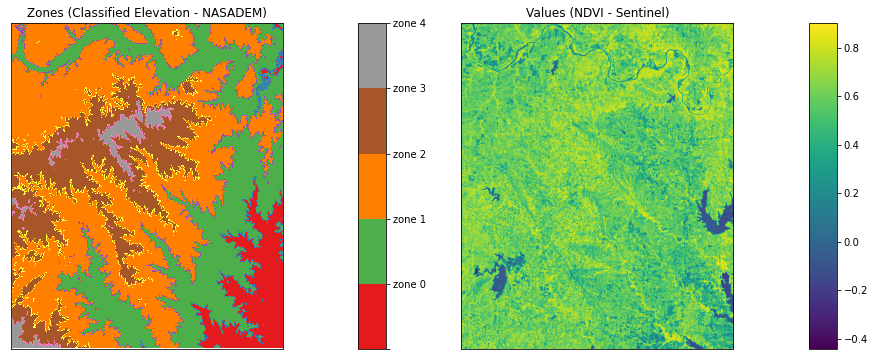

In [18]:
plot_imgs(
    imgs=[quantile_zones, ndvi_values],
    cmaps=["Set1", "viridis"],
    cats=[elevation_zones],
    figsize=(12, 6),
)

Finally, use the [xrspatial.zonal.stats](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) function to combine data from your zone raster (the NASADEM-based elevation zones) and your value raster (the Sentinel-based NDVI data). For each of the five elevation zones in the zonal raster, this function calculates various statistics based on the NDVI data in the value raster. The function returns a DataFrame where each row represents a zone. The columns of the DataFrame contain the following seven statistics calculated from the NDVI data:

1. Mean
2. Max
3. Min
4. Sum
5. Std
6. Var
7. Count

This example considers three of those statistics, mean, max, and min. As you already know all the zones that are available in the zone raster, you can provide them directly to the function as a list. Let's set `zone_ids=[0, 1, 2, 3, 4]` to match five NASADEM elevation classes.

In [19]:
quantile_stats = zonal_stats(
    zones=quantile_zones,
    values=ndvi_values,
    zone_ids=[0, 1, 2, 3, 4],
    stats_funcs=["mean", "max", "min"],
).set_index("zone")

quantile_stats.compute()

,mean,max,min
zone,,,
0,0.440738,0.900511,-0.419831
1,0.585294,0.899222,-0.443129
2,0.579834,0.893552,-0.414806
3,0.603123,0.888252,-0.351653
4,0.614063,0.875973,-0.183576


#### Statistics of NDVI values over Land Cover classes

In this use case, you'll use the land cover data as a zone raster to compute the average NDVI values for each zone. The results should demonstrate how NDVI changes over land use classes. As you already know all the zones beforehand, you can provide value for `zone_ids` to specify the zones that will be analysed.

In [20]:
landcover_ndvi_stats = zonal_stats(
    zones=landcover_data,
    values=ndvi_values,
    zone_ids=list(landcover_data_classes.keys()),
    stats_funcs=["mean", "count"],
)

(
    landcover_ndvi_stats.compute()
    .assign(zone=lambda df: df.zone.map(landcover_data_classes))
    .set_index("zone")
)

,mean,count
zone,,
water,0.017967,45086
trees,0.743269,339212
grass,0.583745,323841
flooded veg,0.547517,1573
crops,0.510045,241748
scrub,0.577804,336765
built area,0.494178,197760
bare,0.087494,4770


## Compute zonal cross-tabulation statistics

The [xrspatial.zonal.crosstab](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.crosstab.html) function calculates cross-tabulated areas between the zone raster and value raster. This function requires a 2D zone raster and a categorical value raster of 2D or 3D data. 

The `crosstab` function calculates different cross-tabulation statistics. It has an `agg` parameter to define which aggregation method to use. It returns a DataFrame where each row represents a zone from the zone raster and each column represents a category from the value raster. 

This example uses the NASADEM elevation zones from earlier as its zone raster. It uses the Esri Land Cover data as its categorical value raster. The resulting DataFrame will show the percentage of each land cover category for each of the five elevation zones. For each of the elevation categories, you will be able to see what percentage of the land is covered in trees, grass, or water, for example.

Let's plot both the five NASADEM elevation classes and Esri's eight landcover classes next to each other:

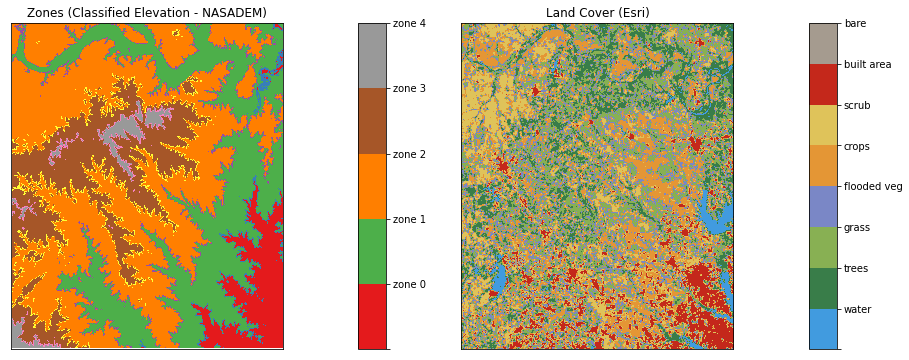

In [21]:
plot_imgs(
    imgs=[quantile_zones, landcover_data],
    cmaps=["Set1", landcover_cmap],
    cats=[elevation_zones, landcover_data_classes.values()],
    figsize=(12, 6),
)

Finally, calculate the cross-tabulation statistics and display a table demonstrating how the land cover categories are distributed over each of the five elevation zones. Set values for `zone_ids` and `cat_ids` to indicate the zones and the categories of interest. In this example, we'll use all the available zones and categories.

In [22]:
crosstab_elev_landcover = zonal_crosstab(
    zones=quantile_zones,
    values=landcover_data,
    zone_ids=[0, 1, 2, 3, 4],
    cat_ids=list(landcover_data_classes.keys()),
    agg="percentage",
)

# rename the columns to match Land Cover class definition
crosstab_elev_landcover.columns = ["zone", *landcover_data_classes.values()]

crosstab_elev_landcover.compute().set_index("zone")

,water,trees,grass,flooded veg,crops,scrub,built area,bare
zone,,,,,,,,
0,19.194996,16.619237,10.637621,0.399138,7.483612,7.121751,38.353624,0.190022
1,2.032851,23.408673,22.159019,0.109825,20.203309,13.815892,17.736924,0.533506
2,2.079317,20.613488,23.654159,0.091228,16.643155,27.866330,8.754948,0.297375
3,0.597121,27.804316,21.287271,0.029408,14.039335,28.293848,7.857609,0.091092
4,0.220107,34.809348,19.252929,0.003237,6.179193,32.320192,6.758594,0.456399


## Next steps: analyze different datasets

The [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/catalog) includes petabytes of environmental monitoring data. All data sets are available in consistent, analysis-ready formats. You can access them through APIs as well as directly via [Azure Storage](https://docs.microsoft.com/en-us/azure/storage/). 

Try using [xrspatial.zonal.stats](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) and [xrspatial.zonal.crosstab](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.crosstab.html) with different datasets from the [Data Catalog](https://planetarycomputer.microsoft.com/catalog). For example, try using the land cover categories from the [Esri 10m Land Cover](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac) dataset as zonal raster. Or try using the [Map of Biodiversity Importance (MoBI)](https://planetarycomputer.microsoft.com/dataset/mobi) dataset as a values raster.

There are also [other zonal functions in xarray spatial](https://xarray-spatial.org/reference/zonal.html) to use with your datasets.

